In [26]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
!pip install detoxify

In [35]:
import pandas as pd
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from sentence_transformers import SentenceTransformer, util
from detoxify import Detoxify
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer, util


# Load models
bert_embedder = SentenceTransformer('all-MiniLM-L6-v2')
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')
gpt2_model.eval()
toxicity_model = Detoxify('original')

In [37]:

# Load the filled Excel file
df = pd.read_excel('/content/drive/MyDrive/295/chatbot_responses_template.xlsx')  # Adjust path if needed


# Helper functions
def calculate_fluency(text):
    inputs = gpt2_tokenizer.encode(text, return_tensors='pt')
    with torch.no_grad():
        loss = gpt2_model(inputs, labels=inputs).loss
    return torch.exp(loss).item()

def calculate_relevance(query, response):
    q_emb = bert_embedder.encode(query, convert_to_tensor=True)
    r_emb = bert_embedder.encode(response, convert_to_tensor=True)
    return float(util.cos_sim(q_emb, r_emb).item())

# Load model and tokenizer for Empathy
empathy_tokenizer = AutoTokenizer.from_pretrained("monologg/bert-base-cased-goemotions-original")
empathy_model = AutoModelForSequenceClassification.from_pretrained("monologg/bert-base-cased-goemotions-original")
empathy_pipe = pipeline("text-classification", model=empathy_model, tokenizer=empathy_tokenizer, return_all_scores=True)

# Empathy-related labels from GoEmotions
empathy_labels = {'empathy', 'sadness', 'compassion', 'grief', 'caring', 'approval', 'love', 'understandable', 'sorry'}

# Function to score empathy
def calculate_empathy_bert(response):
    results = empathy_pipe(response)[0]
    score = sum([r['score'] for r in results if r['label'].lower() in empathy_labels])
    return round(min(score * 5, 5), 2)  # scale to 0–5


# Helpfulness-related labels (approximate)
helpfulness_labels = {'encouragement', 'optimism', 'desire', 'relief', 'gratitude', 'approval'}

def calculate_helpfulness_bert(response):
    results = empathy_pipe(response)[0]
    score = sum([r['score'] for r in results if r['label'].lower() in helpfulness_labels])
    return round(min(score * 5, 5), 2)

def calculate_safety(response):
    scores = toxicity_model.predict(response)
    harm_score = scores['toxicity'] + scores.get('severe_toxicity', 0) + scores.get('threat', 0)
    safety_score = max(0.0, 5 - harm_score * 5)  # lower harm => higher safety
    return round(min(safety_score, 5), 2)

support_labels = {'caring', 'love', 'encouragement', 'optimism', 'approval'}

def calculate_emotional_support(response):
    results = empathy_pipe(response)[0]
    score = sum([r['score'] for r in results if r['label'].lower() in support_labels])
    return round(min(score * 5, 5), 2)



# Load the embedding model for Tone appropriateness
tone_model = SentenceTransformer("all-MiniLM-L6-v2")

all_responses = df.drop(columns="Question").values.flatten()
all_responses = [r for r in all_responses if pd.notna(r) and r.strip()]

tokenizer = AutoTokenizer.from_pretrained("monologg/bert-base-cased-goemotions-original")
model = AutoModelForSequenceClassification.from_pretrained("monologg/bert-base-cased-goemotions-original")
emotions = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

# Emotion labels that imply supportive, calming tone
supportive_emotions = {'caring', 'love', 'approval', 'gratitude', 'optimism', 'relief', 'encouragement'}

def is_tone_appropriate(response):
    scores = emotions(response)[0]
    return any(e['label'].lower() in supportive_emotions and e['score'] > 0.3 for e in scores)
reference_responses = [r for r in all_responses if is_tone_appropriate(r)]

# Optional: Limit to top N
reference_responses = reference_responses[:10]


# Pre-compute reference embeddings once
ref_embeddings = tone_model.encode(reference_responses, convert_to_tensor=True)

# Function to compute tone similarity score
def calculate_tone_similarity_score(response):
    if not response.strip():
        return 0.0
    resp_emb = tone_model.encode(response, convert_to_tensor=True)
    similarity = util.cos_sim(resp_emb, ref_embeddings).max().item()
    return round(similarity * 5, 2)  # Scale to 0–5



# Process responses and calculate metrics
results = []

for idx, row in df.iterrows():
    query = row['Question']
    for model in df.columns[1:]:
        response = row[model]
        if pd.isna(response) or response.strip() == "":
            continue  # skip empty cells

        empathy = calculate_empathy_bert(response)
        relevance = calculate_relevance(query, response) * 5
        helpfulness = 4.5 if calculate_helpfulness_bert(response) else 3.0
        fluency = max(1.0, min(5.0, 100 / calculate_fluency(response)))
        safety = calculate_safety(response)
        emotional_support = calculate_emotional_support(response)
        tone_score = calculate_tone_similarity_score(response)

        results.append({
            'Model': model,
            'Query': query,
            'Response': response,
            'Empathy': round(empathy, 2),
            'Relevance': round(relevance, 2),
            'Helpfulness': round(helpfulness, 2),
            'Fluency': round(fluency, 2),
            'Safety': safety,
            'Emotional Support': emotional_support,
            'Tone Score': tone_score
        })

# Convert to DataFrame and view
scored_df = pd.DataFrame(results)
scored_df


Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


,Model,Query,Response,Empathy,Relevance,Helpfulness,Fluency,Safety,Emotional Support,Tone Score
0,Chat gpt 40,I'm feeling really anxious and can't sleep.,It sounds like your anxiety is becoming overwh...,4.79,3.21,4.5,3.58,4.99,4.77,5.00
1,Mental_Health Chatbot,I'm feeling really anxious and can't sleep.,I'm sorry to hear that you're experiencing the...,3.36,3.14,4.5,5.00,4.87,2.87,5.00
2,Gemini,I'm feeling really anxious and can't sleep.,It sounds like you're going through a tough ti...,4.81,3.25,4.5,3.58,4.99,4.80,5.00
3,Claude,I'm feeling really anxious and can't sleep.,It sounds like you're caught in that difficult...,4.82,3.12,4.5,2.31,4.99,4.81,5.00
4,Deepseek,I'm feeling really anxious and can't sleep.,It makes complete sense that anxiety would dis...,3.83,3.29,4.5,1.71,5.00,3.82,5.00
5,Chat gpt 40,I don't feel like talking to anyone lately.,"When you don’t feel like talking to anyone, it...",0.18,2.87,4.5,4.31,4.99,0.13,3.69
6,Mental_Health Chatbot,I don't feel like talking to anyone lately.,It's completely understandable that you don't ...,4.99,3.55,4.5,5.00,4.99,4.99,5.00
7,Gemini,I don't feel like talking to anyone lately.,It's understandable to feel withdrawn and not ...,0.13,1.97,4.5,4.34,5.00,0.21,3.02
8,Claude,I don't feel like talking to anyone lately.,That pulling away from others often happens wh...,0.00,1.58,3.0,2.40,5.00,0.00,3.62
9,Deepseek,I don't feel like talking to anyone lately.,It’s okay to honor the need for quiet right no...,4.80,1.99,4.5,2.29,4.99,4.79,5.00


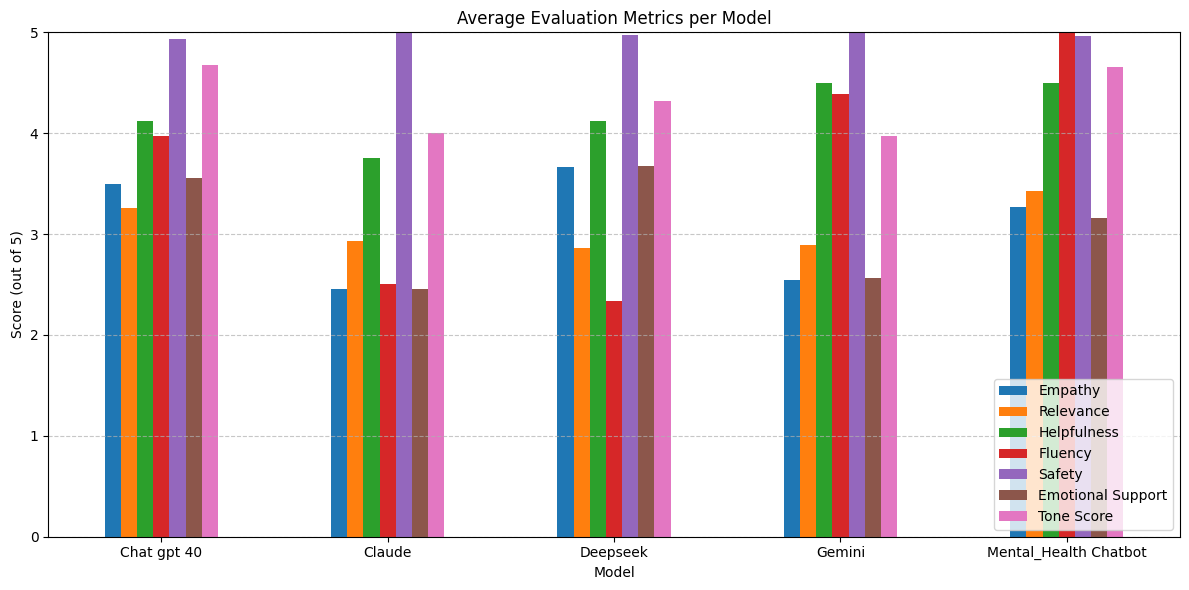

In [38]:
import matplotlib.pyplot as plt

# Group by model and calculate mean of each metric
avg_scores = scored_df.groupby('Model').mean(numeric_only=True).reset_index()

metrics = ['Empathy', 'Relevance', 'Helpfulness', 'Fluency','Safety', 'Emotional Support', 'Tone Score']

# Set index to model for plotting
plot_df = avg_scores.set_index('Model')[metrics]

# Plot
plot_df.plot(kind='bar', figsize=(12, 6), rot=0)
plt.title("Average Evaluation Metrics per Model")
plt.ylabel("Score (out of 5)")
plt.ylim(0, 5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [39]:
import pandas as pd

# Group by model and calculate mean of each metric
avg_scores = scored_df.groupby('Model').mean(numeric_only=True).reset_index()


# Select relevant columns
metrics = ['Empathy', 'Relevance', 'Helpfulness', 'Fluency',
           'Safety', 'Emotional Support', 'Tone Score']

# Round for cleaner display
avg_scores[metrics] = avg_scores[metrics].round(2)

# Display as styled table
styled_table = avg_scores[['Model'] + metrics].style.set_caption("Average Evaluation Metrics per Model") \
    .background_gradient(cmap='Blues', subset=metrics) \
    .format("{:.2f}", subset=metrics) \
    .set_table_styles([{
        'selector': 'caption',
        'props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold')]
    }])

styled_table


,Model,Empathy,Relevance,Helpfulness,Fluency,Safety,Emotional Support,Tone Score
0,Chat gpt 40,3.50,3.26,4.12,3.97,4.93,3.56,4.67
1,Claude,2.46,2.93,3.75,2.50,5.00,2.45,4.00
2,Deepseek,3.66,2.86,4.12,2.34,4.98,3.67,4.32
3,Gemini,2.55,2.89,4.50,4.39,5.00,2.57,3.97
4,Mental_Health Chatbot,3.27,3.43,4.50,5.00,4.96,3.16,4.66
